In [1]:
import os
import pandas as pd
import numpy as np
import arviz as az
import bambi as bmb
import numpy as np
import scipy

from stratification import chromosome_splits

def to_pandas(x):
    return pd.DataFrame(x.numpy())

def spearman_scoring(y, y_true):
    return scipy.stats.spearmanr(y, y_true)[0]

def get_formula(feature_names):
    """Generates the formula required for the bambi generalized linear model (GLM)
    
    :param feature_names: extracted columns names as list of string
    :type feature_names: list
    
    :return: a string formula containing the GLM functional formulae
    :rtype: string
    """
    template = ['{}'] * (len(feature_names))
    template = " + ".join(template)
    template = template.format(*list(feature_names))
    f = 'y ~ ' + template
    return f

# Import the data from csv
x_train = pd.read_csv('x_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
x_train['y'] = y_train

# inport test data
x_test = pd.read_csv('x_test.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)
x_train.columns = ['col_{}'.format(i) for i in x_train.columns[:-1].values] + ['y']
x_test.columns = ['col_{}'.format(i) for i in x_test.columns.values] 

# Define parameters
params = {
    'family': 'negativebinomial',
    'chains': 3,
    'draws': 1000,
    'tune': 5000}


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Get the function formula + model
f = get_formula(x_train.columns[:-1])
model = bmb.Model(f, x_train, family=params['family'])

# Fit model
fitted_model = model.fit(draws=params['draws'], tune=params['tune'],
                        chains=params['chains'], init='adapt_diag')
# Get mean posterior predictions
idata = model.predict(fitted_model, data=x_test, inplace=False)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [y_alpha, col_139, col_138, col_137, col_136, col_135, col_134, col_133, col_132, col_131, col_130, col_129, col_128, col_127, col_126, col_125, col_124, col_123, col_122, col_121, col_120, col_119, col_118, col_117, col_116, col_115, col_114, col_113, col_112, col_111, col_110, col_109, col_108, col_107, col_106, col_105, col_104, col_103, col_102, col_101, col_100, col_99, col_98, col_97, col_96, col_95, col_94, col_93, col_92, col_91, col_90, col_89, col_88, col_87, col_86, col_85, col_84, col_83, col_82, col_81, col_80, col_79, col_78, col_77, col_76, col_75, col_74, col_73, col_72, col_71, col_70, col_69, col_68, col_67, col_66, col_65, col_64, col_63, col_62, col_61, col_60, col_59, col_58, col_57, col_56, col_55, col_54, col_53, col_52, col_51, col_50, col_49, col_48, col_47, col_46, col_45, col_44, col_43, col_42, col_41, col_40, col_39, col_38, col_37, col_36, 

Sampling 3 chains for 5_000 tune and 1_000 draw iterations (15_000 + 3_000 draws total) took 13198 seconds.
There were 589 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 578 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [3]:

preds = np.mean(idata.posterior['y_mean'].values, axis=(0, 1)).reshape(-1, 1)
print(np.shape(preds))


(3730, 1)


In [4]:
print(spearman_scoring(preds, y_test))

0.709927144734433


/mnt/mnemo5/sum02dean/miniconda3/envs/bambi-env/lib/python3.10/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (143), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'col_0'}>,
        <AxesSubplot:title={'center':'col_0'}>],
       [<AxesSubplot:title={'center':'col_1'}>,
        <AxesSubplot:title={'center':'col_1'}>],
       [<AxesSubplot:title={'center':'col_2'}>,
        <AxesSubplot:title={'center':'col_2'}>],
       [<AxesSubplot:title={'center':'col_3'}>,
        <AxesSubplot:title={'center':'col_3'}>],
       [<AxesSubplot:title={'center':'col_4'}>,
        <AxesSubplot:title={'center':'col_4'}>],
       [<AxesSubplot:title={'center':'col_5'}>,
        <AxesSubplot:title={'center':'col_5'}>],
       [<AxesSubplot:title={'center':'col_6'}>,
        <AxesSubplot:title={'center':'col_6'}>],
       [<AxesSubplot:title={'center':'col_7'}>,
        <AxesSubplot:title={'center':'col_7'}>],
       [<AxesSubplot:title={'center':'col_8'}>,
        <AxesSubplot:title={'center':'col_8'}>],
       [<AxesSubplot:t

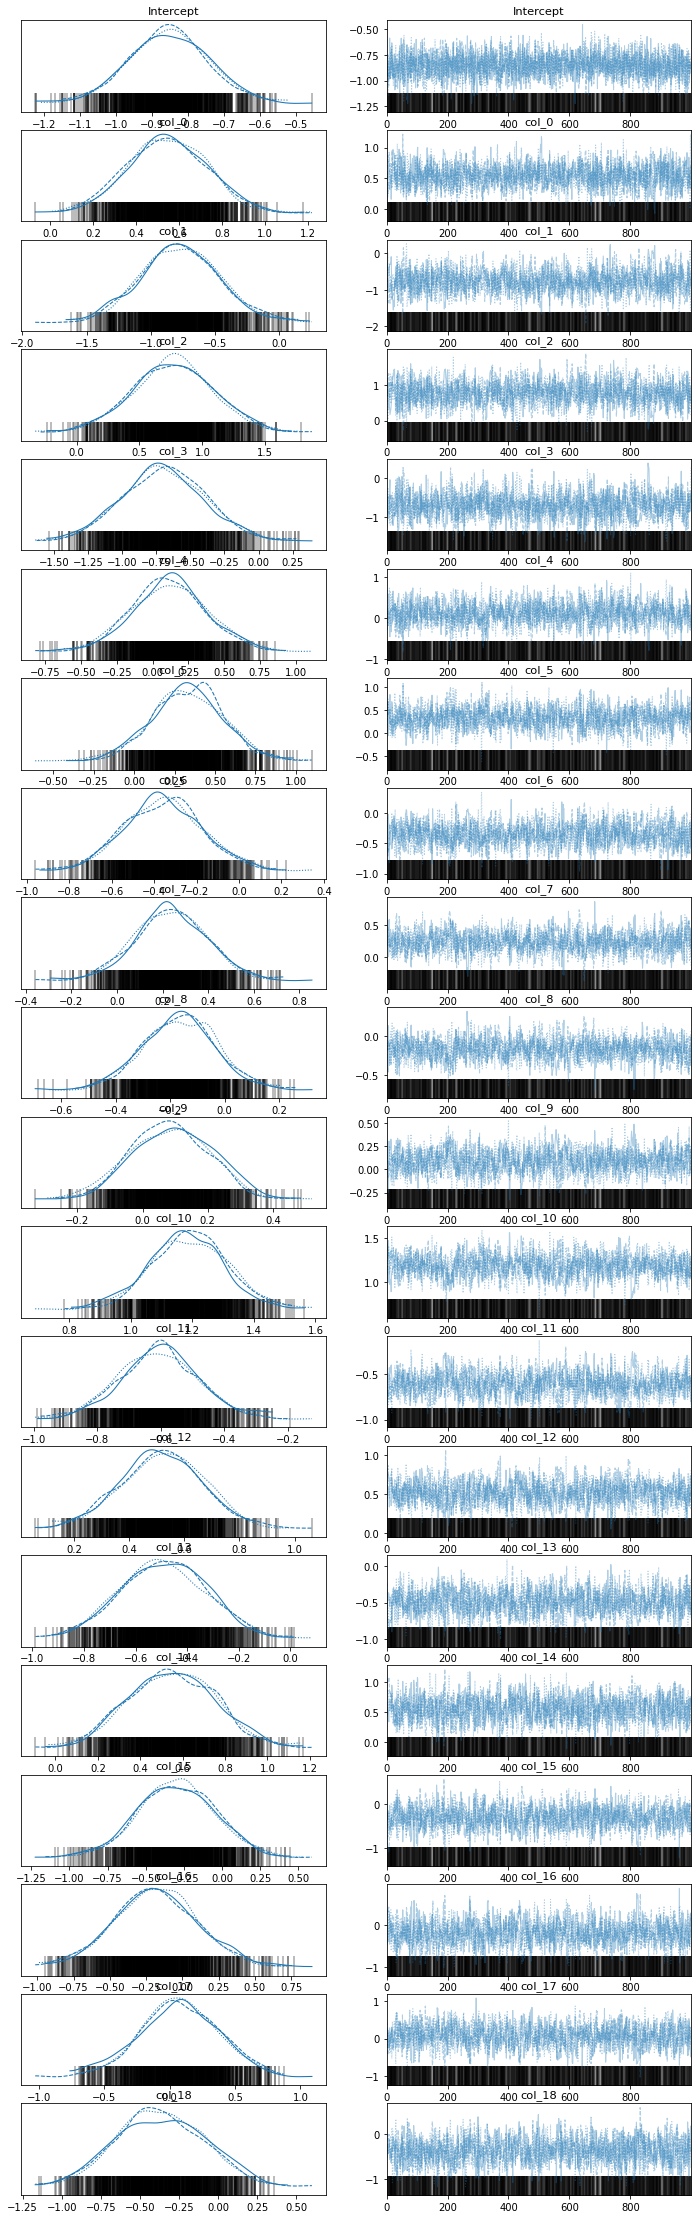

In [6]:
az.plot_trace(idata)

In [5]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.854,0.110,-1.048,-0.631,0.002,0.001,2838.0,2319.0,1.0
col_0,0.547,0.184,0.182,0.869,0.005,0.004,1322.0,1675.0,1.0
col_1,-0.770,0.309,-1.329,-0.165,0.009,0.006,1143.0,919.0,1.0
col_2,0.767,0.321,0.163,1.377,0.010,0.007,1074.0,1148.0,1.0
col_3,-0.698,0.311,-1.250,-0.079,0.009,0.007,1083.0,1382.0,1.0
...,...,...,...,...,...,...,...,...,...
y_mean[3725],6.180,3.267,1.713,12.304,0.115,0.081,663.0,1365.0,1.0
y_mean[3726],0.582,0.088,0.428,0.749,0.002,0.001,1918.0,1893.0,1.0
y_mean[3727],0.440,0.060,0.328,0.553,0.001,0.001,1734.0,1897.0,1.0
y_mean[3728],0.415,0.145,0.182,0.686,0.003,0.002,1708.0,1938.0,1.0


In [19]:
y_hat = np.mean(idata.posterior['y_mean'], axis=1).values

In [28]:
y_hat2 = pd.DataFrame(y_hat).T

In [34]:
score = []
for i in range(3):
    s = spearman_scoring(y_test, y_hat2.iloc[:, i])
    score.append(s)

    
print(score)
print(np.std(score))
print(np.var(score))




[0.7104062515738008, 0.7099251031018303, 0.7096394053374108]
0.0003164350407165125
1.0013113499326094e-07
